In [1]:
import os, sys
from math import sqrt, isnan

# setting the utilities required for loading the data
sys.path.append('utilities/')

from loadDataUtility import *
from graphGenerationUtilities import *

2023-05-08 13:08:39.206121: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [2]:
def load_data_nicv(params):
    """
    This function loads the dataset required.
    """
    print('preparing data ...')
    target_byte = params['target_byte']
    start_idx, end_idx = params["start_idx"], params["end_idx"]
    file_name = params["input_path"]
    
    train_data_whole_pack = np.load(file_name)
    print("access file: {}".format(file_name))
    data_info(train_data_whole_pack)

    print('-'*80)
    print('processing data...')
    power_traces, labels = gen_features_and_labels_256_nicv(train_data_whole_pack,
                                                            target_byte,
                                                            start_idx, end_idx)

    power_traces = power_traces[:params["n"], :]
    labels = labels[:params["n"]]

    print('reshaped power traces: ', power_traces.shape)
    print('shape of the labels: ', labels.shape)

    return power_traces, labels
def gen_features_and_labels_256_nicv(data, input_target_byte, start_index, end_index):
    """
    This function generates features and labels for the dataset.
    Although similar, this function differs somewhat from the one present in the Step 2.1 notebook.
    It differs from the corresponding function in the TVLA notebook as well.
    """
    # loading the dataset
    try:
        power_traces, plain_text, key = data['trace_mat'], data['textin_mat'], data['key']
    except:
        power_traces, plain_text, key = data['power_trace'], data['plain_text'], data['key']
    
    # Getting the key_byte_value AKA label
    key_byte_value = key[input_target_byte]

    print('generating features and labels for the key byte value: ', key_byte_value)

    labels = [] 
    for i in range(plain_text.shape[0]):
        text_i = plain_text[i]
        # Some plain text values are stored as floats so they must be converted to an int before using bitwise xor
        label = aes_internal(int(text_i[input_target_byte]), key_byte_value) #key[i][input_key_byte]
        labels.append(label)

    labels = np.array(labels)
    if not isinstance(power_traces, np.ndarray):
        power_traces = np.array(power_traces)
    power_traces = power_traces[:, start_index:end_index]

    return power_traces, labels
    
def calculate_nicv_values3(labels_arr, Y_var):
    '''
    This function computes the nicv values (mean, variance, NICV) of the labels_arr
    '''
    Z = [] # A 1D array containing the means of each label (row) is instantiated (AKA Z array).
    for i in range(np.shape(labels_arr)[0]): # Each row (power traces with specific label) is iterated through.
        non_zero_elements = labels_arr[i][labels_arr[i] != 0] # The non-zero elements of the current row are saved.
        if not(len(non_zero_elements)): # If there is a label with no power traces, the mean is set to 0.
            continue
        else: # Else, the average of the current row's non-zero elements are calculated.
            Z.append(np.average(non_zero_elements))

    
    Z_var = np.var(Z, ddof=1) # The variance of the Z array is calculated.
    if isnan(Z_var/Y_var):
        return 0
    return Z_var/Y_var # NICV is returned

def save_NICV(power_traces, NICV_vals, path_to_save_nicv):
    '''
    This function saves the nicv results to a csv file.
    '''
    # The file name is of the format: "target-byte-x"
    # The thought is that the parent directories will provide the necessary information as to what this file name represents.
    f_name = "target-byte-{}".format(target_byte+1)
    nicv_file_path = path_to_save_nicv + '-{}.csv'.format(f_name)
    
    # Data is an iterator of tuples. These tuples contain the time (incremented by 1) and the corresponding t-value.
    data = zip(range(data_params["start_idx"] + 1, data_params["end_idx"] + 1), NICV_vals)
    nicv_df = pd.DataFrame(list(data))
    nicv_df.to_csv(nicv_file_path, index=False, header=["time", "nicv-value"])
    print("Normalized Inter-Class Variance results sucessfully saved to csv file: {}".format(nicv_file_path))
    return nicv_file_path
def compute_normalized_inter_class_variance(power_traces, labels, debug=False):
    '''
    This function computes the normalized inter-class variance.
    '''
    NICV_vals = []
    for i in range(np.shape(power_traces)[1]): # Each column (time) of the power_traces array is analyzed.
        curr_power_traces_col = power_traces[:,i]
        var_curr_power_traces_col = np.var(curr_power_traces_col, ddof=1) # The variance of the current column is calculated for NICV.
        labels_arr = np.zeros((256, power_traces.shape[0])) # NOTE: For debugging, replace the "256" with the length of debug key_byte_values (3)
        for j in range(np.shape(curr_power_traces_col)[0]): # Each row of the current power traces column is analyzed.
            labels_arr[labels[j]][j] = curr_power_traces_col[j]
        NICV = calculate_nicv_values3(labels_arr, var_curr_power_traces_col)
        NICV_vals.append(NICV)
    return NICV_vals
def ReduceNICV(nicv):
    s=[]
    for i in range(np.size(nicv)):
        if(nicv[i]>1):
            s.append(1)
        else:
            s.append(nicv[i])
    return s
def save_NICV(power_traces, NICV_vals, str_target_byte, path_to_save_nicv):
    '''
    This function saves the nicv results to a csv file.
    '''
    # The file name is of the format: "target-byte-x"
    # The thought is that the parent directories will provide the necessary information as to what this file name represents.
    f_name = "target-byte-" + str_target_byte
    nicv_file_path = os.path.join(path_to_save_nicv, f_name + '.csv')
    
    # Data is an iterator of tuples. These tuples contain the time (incremented by 1) and the corresponding t-value.
    data = zip(range(data_params["start_idx"] + 1, data_params["end_idx"] + 1), NICV_vals)
    nicv_df = pd.DataFrame(data)
    nicv_df.to_csv(nicv_file_path, index=False, header=["time", "nicv-value"])
    print("Normalized Inter-Class Variance results sucessfully saved to csv file: {}".format(nicv_file_path))

In [3]:
def plot_figures(data_params, nicv_results, dataset_name,label):
    nicv_path = data_params
    
    # The x ticks are calculated. There is some variability with these values between masked and unmasked (due to num_time_samples)
    # so, code was introduced to account for the differences.
    num_time_samples = nicv_results.shape[0]
    time_samples_inc = num_time_samples // 5
    # The first time value is the start_idx + 1.
    # For better formatting of the results, the x-ticks begin from one less than this.
    first_time_val = nicv_results['time'][0]
    x_ticks = list(range(data_params['start_idx'], data_params['end_idx'], 1000))
    x_ticks.append(data_params['end_idx'])
    
    fig = plt.figure(figsize=(10, 6))
    ax = fig.add_subplot(111)
    
    ax.plot(nicv_results['time'], nicv_results['nicv-value'], color='blue', linestyle='-', linewidth=4, alpha=0.9,
            label=label)

    plt.legend(fontsize=28, loc=0)
    #plt.legend([dataset_name])
    plt.xlabel('Points of Interests',fontsize=28)
    plt.ylabel("NICV",fontsize=28)
    plt.xticks(x_ticks,fontsize=28)
    plt.yticks([0, 0.2, 0.4, 0.6, 0.8, 1],fontsize=28)

    plt.show()
    print(data_params)

def loadCSVData(data_params):
    # Read the csv file containing the NICV results
    nicv_path = data_params
    try:
        nicv_results = pd.read_csv(nicv_path)
    except OSError:
        print("could not access {}".format(nicv_path))
        sys.exit()

    nicv_results.head()
    return nicv_results

In [4]:
root_dir = '/home/mabon/old/complete/OneDrive_datasets/original/xmega_unmasked/'
dname = ''
fname = 'X1_K1_200k.npz'
attack_window = [2350, 2600]
target_byte = 2
data_params = {
    "input_path": os.path.join(root_dir, dname, fname), # path to the input file
    "target_byte": target_byte, # byte on which analysis is to be performed
    "start_idx": attack_window[0], # These values depend on the architecture being tested
    "end_idx": attack_window[1],
    "n": 10000, # This value should be equivalent to the number of power traces in the input file
    target_byte: target_byte
}

In [5]:
power_traces, labels = load_data_nicv(data_params)
nicv = compute_normalized_inter_class_variance(power_traces, labels,)
nicv=ReduceNICV(nicv)
save_NICV(power_traces, nicv, "3", "results/")

preparing data ...
access file: /home/mabon/old/complete/OneDrive_datasets/original/xmega_unmasked/X1_K1_200k.npz
shape of the plain text matrix :  (200000, 16)
shape of the power trace matrix:  (200000, 5000)
Encryption key:  [ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
------------------------------------------------------------------------------------------
--------------------------------------------------------------------------------
processing data...
generating features and labels for the key byte value:  21
reshaped power traces:  (10000, 250)
shape of the labels:  (10000,)
Normalized Inter-Class Variance results sucessfully saved to csv file: results/target-byte-3.csv


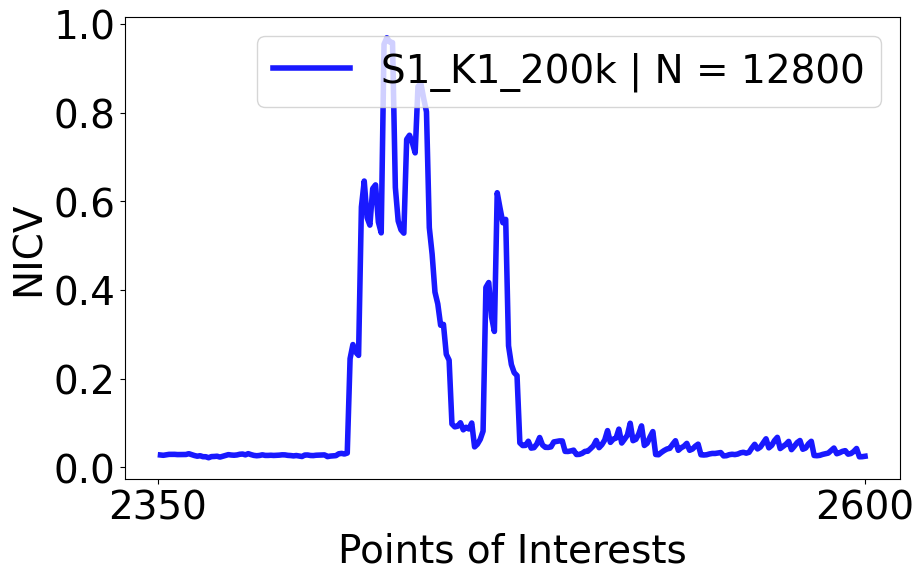

{'input_path': '/home/mabon/old/complete/OneDrive_datasets/original/xmega_unmasked/X1_K1_200k.npz', 'target_byte': 2, 'start_idx': 2350, 'end_idx': 2600, 'n': 10000, 2: 2}


In [6]:
label="S1_K1_200k | N = 12800"
dataset_name=label
# The x ticks are calculated. There is some variability with these values between masked and unmasked (due to num_time_samples)
# so, code was introduced to account for the differences.
nicv_results = loadCSVData("results/target-byte-3.csv")
num_time_samples = nicv_results.shape[0]
time_samples_inc = num_time_samples//5
# The first time value is the start_idx + 1.
# For better formatting of the results, the x-ticks begin from one less than this.
first_time_val = nicv_results['time'][0]
x_ticks = list(range(first_time_val - 1, first_time_val + num_time_samples, time_samples_inc))

plot_figures(data_params, nicv_results, dataset_name,label)


In [23]:
np.shape(power_traces)

(10000, 2000)

In [24]:
np.shape(labels)

(10000,)

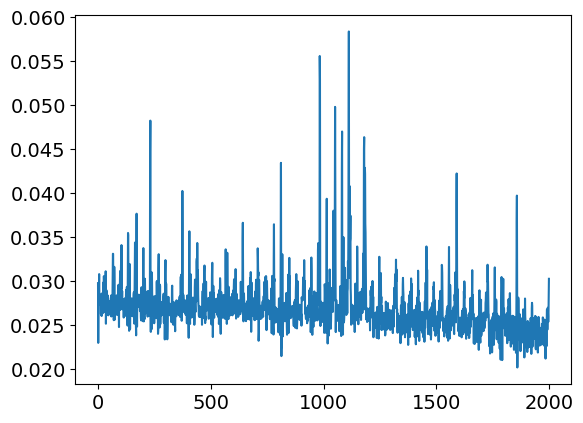

In [25]:
plt.plot(nicv)